In [68]:
%load_ext autoreload
%autoreload 2

# Examine series of models trained with 03_cvae_multi script

In [69]:
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoscaper.model.evaluation import calc_prompt_adherence
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

from evoscaper.utils.preprocess import make_datetime_str

sns.set_context("paper")


In [70]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

In [71]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

dir_source = os.path.join('data', '03_cvae_multi', '2025_02_12__11_48_22')
dirs_source = [os.path.join('data', '03_cvae_multi', k) for k in ['2025_02_08__18_09_53', '2025_02_08__22_15_29', '2025_02_11__13_49_15', '2025_02_11__21_13_15']]
df_hpos = pd.DataFrame()
for d in dirs_source:
    fn_hpos = os.path.join(d, 'df_hpos_main.json')
    df_hpos_i = pd.read_json(fn_hpos)
    df_hpos = pd.concat([df_hpos, df_hpos_i[df_hpos_i['R2_train'] != 'TO_BE_RECORDED']], axis=0)
df_hpos = df_hpos.sort_index()
df_hpos = df_hpos[df_hpos['R2_train'].apply(lambda x: x > 0 if type(x) != str else True)]
df_hpos['mutual_information_conditionality'] = df_hpos['mutual_information_conditionality'].apply(lambda x: np.mean(x) if type(x) == list else x)


In [72]:
output_idx = -1
perc_recall=0.01
df_hpos['precision'] = np.nan
df_hpos['recall'] = np.nan
df_hpos['f1'] = np.nan
for i, r in df_hpos.iterrows():
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')
    if r['R2_train'] > 0.8 and os.path.exists(fn_sample) and os.path.exists(fn_analytics):
        sampled_cond = np.load(fn_sample)
        analytics = load_json_as_dict(fn_analytics)
        analytics['adaptation'] = calculate_adaptation(
            np.array(analytics['sensitivity_wrt_species-6']), np.array(analytics['precision_wrt_species-6']))
        a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None] for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
        precision, recall, f1 = calc_prompt_adherence(sampled_cond, a, perc_recall=perc_recall)
        df_hpos.loc[i, 'precision'] = precision.mean()
        df_hpos.loc[i, 'recall'] = recall.mean()
        df_hpos.loc[i, 'f1'] = f1.mean()



In [73]:
df_hpos.loc[~df_hpos['use_kl_div'], 'kl_weight'] = np.nan
df_hpos['threshold_early_val_acc'] = df_hpos['threshold_early_val_acc'].apply(np.float32)

for c in df_hpos.columns:
    if df_hpos[c].dtype == bool:
        df_hpos[c] = df_hpos[c].astype(str)
        

In [74]:
df_hpos['kl_weight'] = df_hpos['kl_weight'] * 1e4
df_hpos.rename(columns={'kl_weight': 'kl_weight (x10e-4)'}, inplace=True)
# df_hpos.rename(columns={'kl_weight x10e-4': 'kl_weight (x10e-4)'}, inplace=True)


In [82]:
cols_output = ['R2_train', 'precision', 'recall', 'f1']
cols_exclude = ['R2_test', 'mutual_information_conditionality', 'objective_col', 'output_species', 'signal_species']
df_hpos = df_hpos[(df_hpos != 'TO_BE_RECORDED').all(axis=1)]
cols_input = [c for c in df_hpos.columns if (c not in cols_output) and (c not in cols_exclude)]
df_hpos['Objective'] = df_hpos['objective_col'].apply(lambda x: ',\n'.join(x))
# for c in df_hpos.columns:
#     if type(df_hpos[c].iloc[0]) == list: 
#         df_hpos[c] = df_hpos[c].apply(lambda x: ',\n'.join(x) if (x is not None) and (type(x[0]) == str) else np.array(x))
cols_meta = ['filename_saved_model', 'run_successful', 'info_early_stop', 'error_msg', 'total_ds', 'n_batches', 'n_layers_enc', 'n_layers_dec']
cols_exclude = cols_exclude + cols_meta
# cols_outmetric = [c for c in cols_output if c not in cols_meta and (c != 'mutual_information_conditionality')]
cols_outmetric = ['R2_train', 'precision', 'recall', 'f1']
cols_varying = [c for c in cols_input if (c not in cols_exclude) and (df_hpos[c].nunique() > 1)]

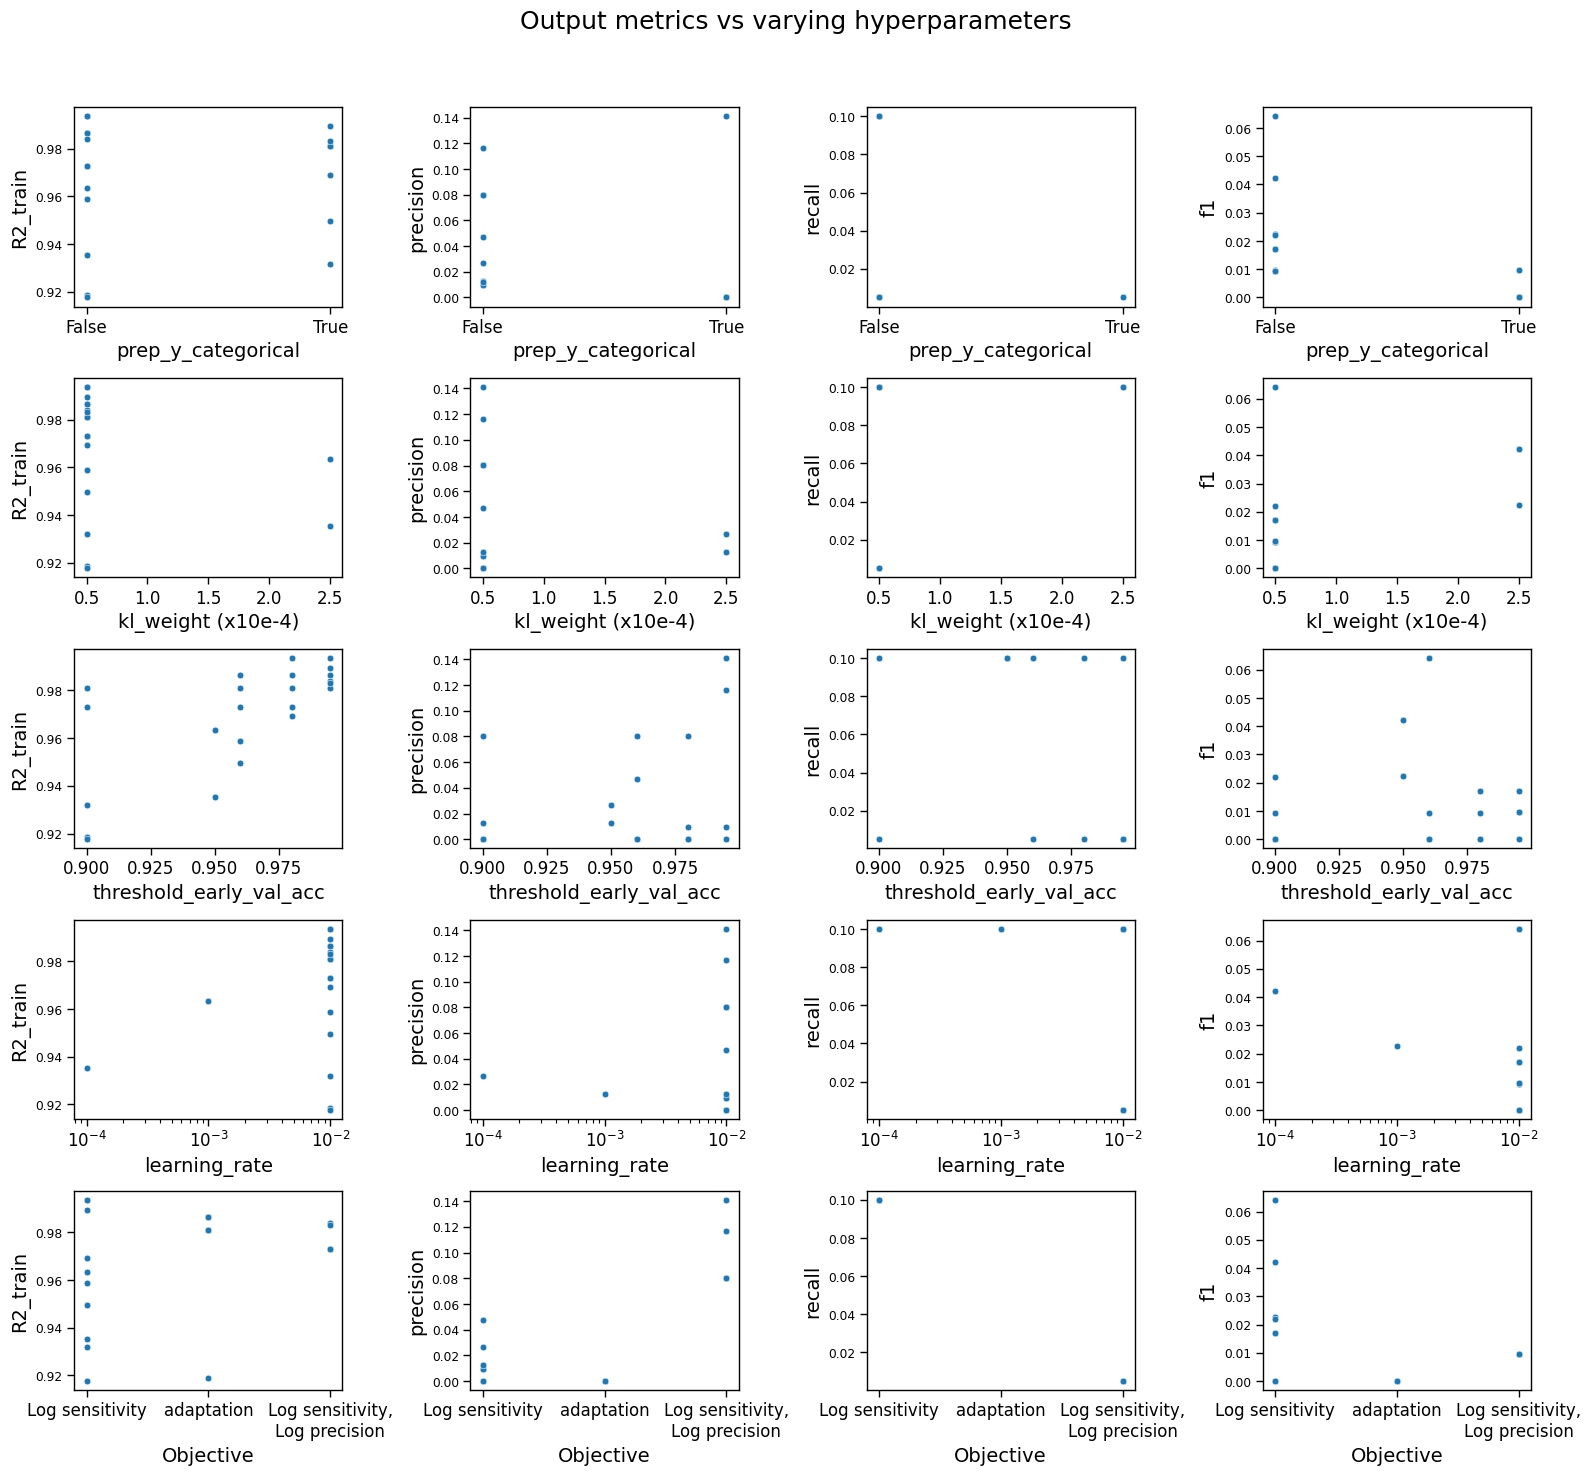

In [83]:
nrows = len(cols_varying)
ncols = len(cols_outmetric)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))

for i, k in enumerate(cols_varying):
    for j, kj in enumerate(cols_outmetric):
        sns.scatterplot(data=df_hpos, x=k, y=kj, ax=axes[i, j])
        if k == 'learning_rate':
            axes[i, j].set_xscale('log')
        axes[i, j].tick_params(axis='x', labelsize=12)
        axes[i, j].set_xlabel(k, fontsize=14)
        axes[i, j].set_ylabel(kj, fontsize=14)
plt.suptitle(f'Output metrics vs varying hyperparameters', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_vs_output_metrics.png'), dpi=300, bbox_inches='tight', transparent=True)


In [86]:
hpos_to_vary_together = [{
    'Objective': [('adaptation',), ('Log sensitivity',), ('Log sensitivity', 'Log precision')],
    'prep_y_categorical': [False, True],
    'use_kl_div': [True],
    # 'kl_weight': [5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4],
    'kl_weight (x10e-4)': np.array([5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4]) * 1e3,
    'threshold_early_val_acc': [0.995, 0.98, 0.96, 0.9],
},
    {
    'use_contrastive_loss': [True],
    'temperature': [0.1, 0.5, 1, 1.5, 2, 4, 8],
    'threshold_similarity': [0.95, 0.9, 0.7, 0.5, 0.3, 0.1],
    'power_factor_distance': [3, 4],
    'threshold_early_val_acc': [0.995, 0.9]
}]

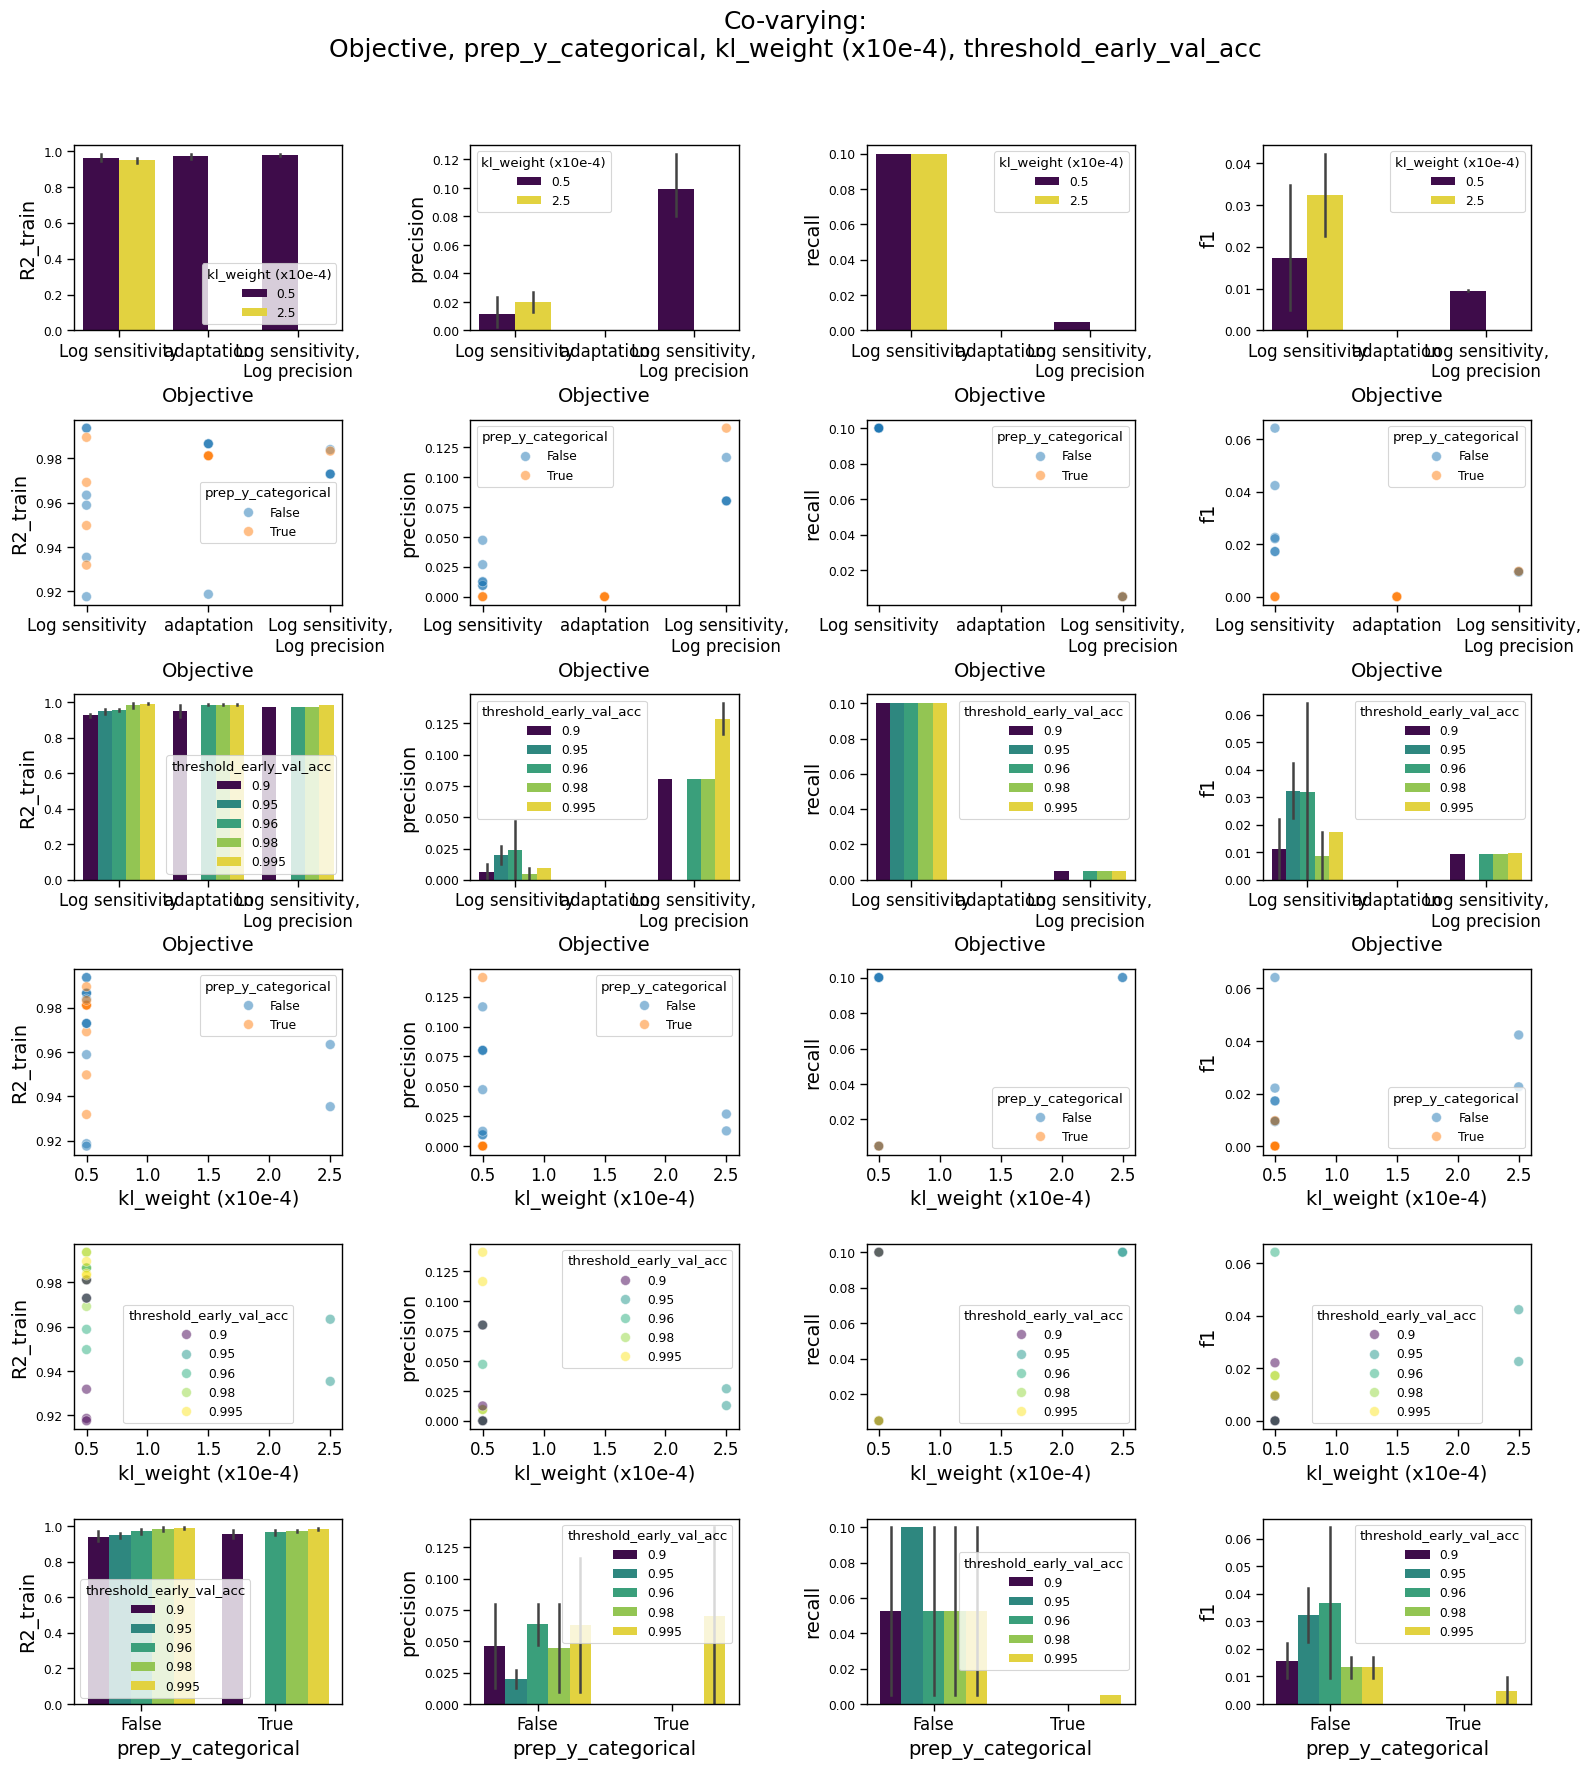

In [87]:
for h in hpos_to_vary_together:
    h_keys = [c for c in h.keys() if df_hpos[c].nunique() > 1]
    combinations = sorted(set([tuple(sorted([i, j])) for i, j in itertools.combinations(h_keys, 2)]))
    ncols = len(cols_outmetric)
    nrows = len(combinations)
    if len(combinations) > 0:
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        for i, (k1, k2) in enumerate(combinations):
            for j, kj in enumerate(cols_outmetric):
                if df_hpos[k1].dtype == object and (df_hpos[k2].iloc[0] not in ['True', 'False']):
                    f = sns.barplot
                    # f = sns.violinplot
                    kwargs = {'palette': 'viridis'}
                else:
                    f = sns.scatterplot
                    kwargs = {'s': 50, 'alpha': 0.5}
                    if k2 == 'threshold_early_val_acc':
                        kwargs.update({'palette': 'viridis'})
                f(data=df_hpos, x=k1, y=kj, hue=k2, ax=axes[i, j], **kwargs)
                axes[i, j].tick_params(axis='x', labelsize=12)
                axes[i, j].set_xlabel(k1, fontsize=14)
                axes[i, j].set_ylabel(kj, fontsize=14)
        plt.suptitle('Co-varying:\n' + ', '.join(h_keys), fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_confounding.png'), dpi=300, bbox_inches='tight', transparent=True)


# Zoom in on KL weight 

In [92]:
choose_kl = [0.5]
choose_objective = ['Log sensitivity', ('Log sensitivity,\nLog precision')]

filt_kl = df_hpos['kl_weight (x10e-4)'].isin(choose_kl) & df_hpos['Objective'].isin(
    choose_objective) & df_hpos['run_successful'] & df_hpos['filename_saved_model'].apply(
        lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'sampled_cond.npy'))) & df_hpos['filename_saved_model'].apply(lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'analytics.json')))


df_train_tables = {}
for k in df_hpos[filt_kl]['filenames_train_table'].unique():
    df_train_table = pd.read_json(r['filenames_train_table']) if r['filenames_train_table'].endswith(
        '.json') else pd.read_csv(r['filenames_train_table'])
    df_train_table['Log sensitivity'] = np.log(
        df_train_table['sensitivity_wrt_species-6'])
    df_train_table['Log precision'] = np.log(
        df_train_table['precision_wrt_species-6'])
    df_train_tables[k] = df_train_table

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: cannot reshape array of size 100000 into shape (100,1000,2)

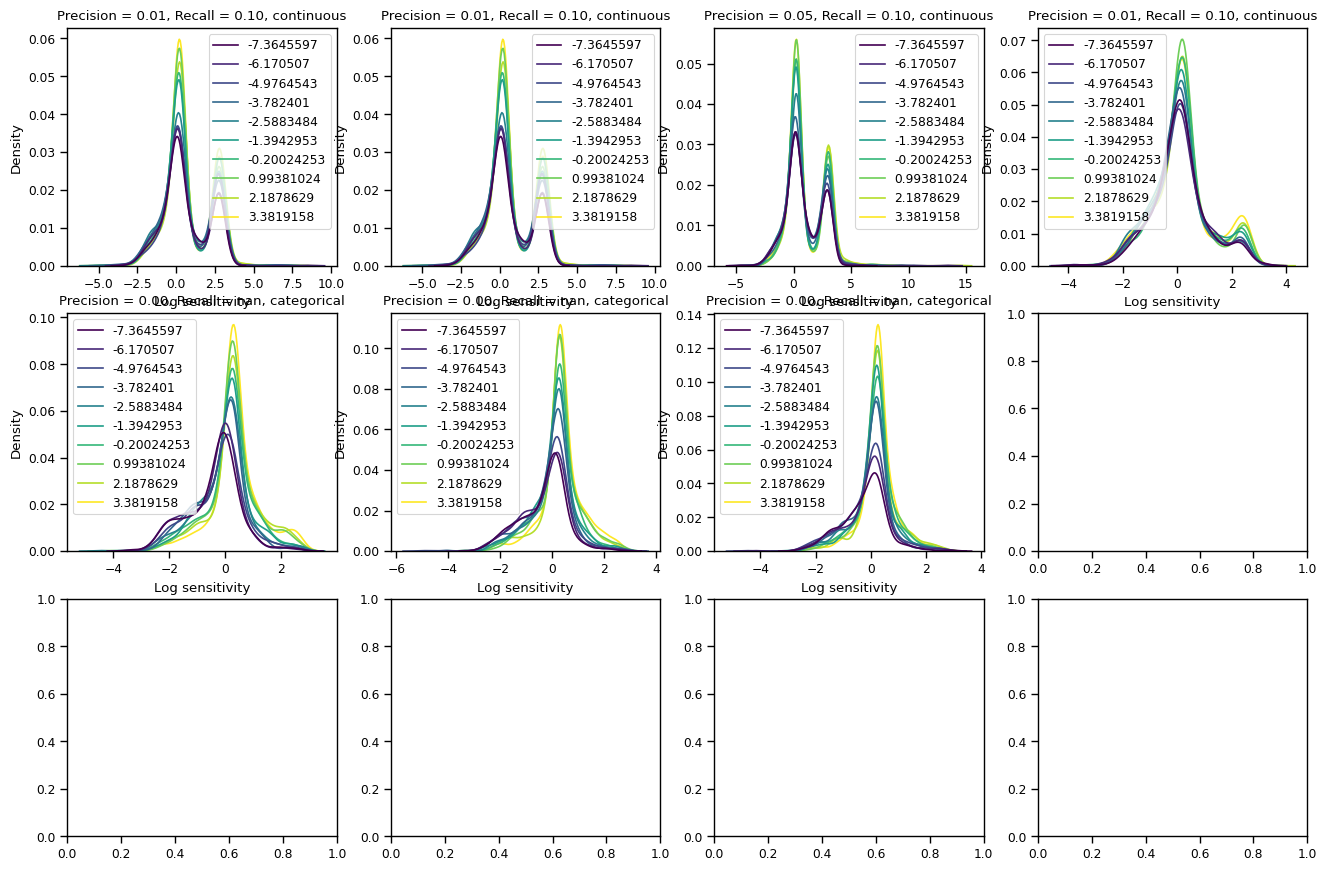

In [135]:
from evoscaper.utils.tuning import make_configs_initial, make_config_model
from evoscaper.utils.dataset import prep_data, adjust_total_ds
from evoscaper.utils.preprocess import make_xcols
import jax

def get_og_sample_cond(sampled_cond, df_train_tables, r):
    data = df_train_tables[r['filenames_train_table']]
    analytic = data[(data['sample_name'] == 'RNA_2') & (data['response_time_wrt_species-6'] < r['filt_response_time_perc_max']*data['response_time_wrt_species-6'].max())][r['objective_col']]
    # analytic = data[data['sample_name'] == 'RNA_2'][r['objective_col']]
    analytic = np.where(np.isinf(analytic), np.nan, analytic)
    
    # rng = jax.random.PRNGKey(int(r['seed_train']))
    # (config_norm_x, config_norm_y, config_filter, config_optimisation,
    #     config_dataset, config_training) = make_configs_initial(r)
    # # config_dataset.objective_col = r['objective_col']
    # x_cols = make_xcols(data, config_dataset.x_type,
    #                     config_dataset.include_diffs)
    # if type(x_cols[-1]) == list:
    #     x_cols = x_cols[:-1]
    # config_filter.filt_n_same_x_max_bins = None
    # df = prep_data(data, [config_dataset.output_species], config_dataset.objective_col,
    #                x_cols, config_filter)
    # TOTAL_DS, N_BATCHES, BATCH_SIZE = adjust_total_ds(
    #     df, config_training.batch_size, config_dataset.total_ds_max)
    # df = df.iloc[jax.random.choice(rng, np.arange(len(df)), [
    #                                TOTAL_DS], replace=False)]

    # analytic = df[config_dataset.objective_col]

    a_range = (np.nanmax(analytic) - np.nanmin(analytic))
    a_min = np.nanmin(analytic) - a_range * 0.1
    a_max = np.nanmax(analytic) + a_range * 0.1

    cond = np.interp(sampled_cond, (sampled_cond.min(),
                     sampled_cond.max()), (a_min, a_max))
    return cond


nrows = 3 #int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
ncols = 4 #int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
for i, (i_df, r) in enumerate(df_hpos[filt_kl].iterrows()):
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')
    
    sampled_cond = np.load(fn_sample)
    analytics = load_json_as_dict(fn_analytics)
    # analytics['adaptation'] = calculate_adaptation(
    #     np.array(analytics['sensitivity_wrt_species-6']), np.array(analytics['precision_wrt_species-6']))
    a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None] for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
    a_resp = np.array(analytics['response_time_wrt_species-6'])[..., output_idx].reshape(*sampled_cond.shape)
    idxs_good = np.where(a_resp.flatten() < r['filt_response_time_perc_max']*a_resp.max())[0]
    # a = np.array(analytics[r['objective_col'].split('\n')])[..., output_idx].reshape(*sampled_cond.shape)
    cond = get_og_sample_cond(sampled_cond, df_train_tables, r)

    sns.kdeplot(x=a.flatten()[idxs_good], hue=cond.flatten()[idxs_good].astype(
        np.float32), palette='viridis', ax=axs.flat[i])
    axs.flat[i].set_title(f'Precision = {r["precision"]:.2f}, Recall = {r["recall"]:.2f}, {"continuous" if r["prep_y_categorical"] != "True" else "categorical"}')
    axs.flat[i].set_xlabel(", ".join(r["objective_col"]))
    
plt.suptitle('Distribution of circuit functions for kl_weight = 0.5', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'distribution_circuit_functions.png'), dpi=300, bbox_inches='tight', transparent=True)

/tmp/ipykernel_776248/4214707968.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_776248/4214707968.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


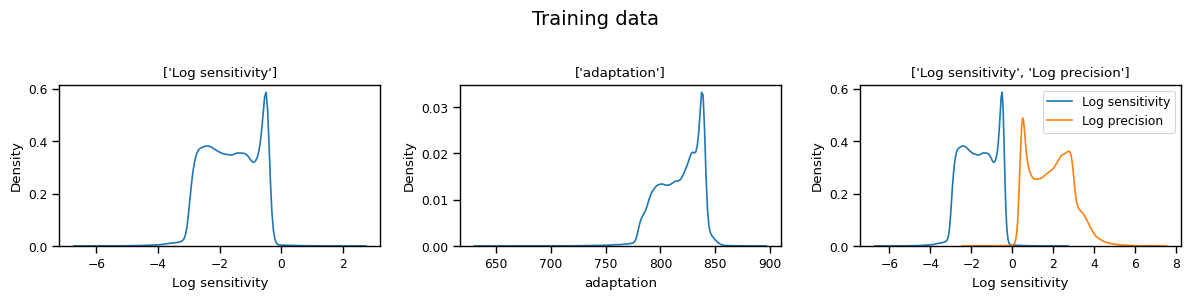

In [130]:
obj_cols = list([df_hpos[df_hpos['Objective'] == o]['objective_col'].iloc[0] for o in df_hpos['Objective'].unique()])
fig, axs = plt.subplots(1, len(obj_cols), figsize=(4*len(obj_cols), 3*1))
for i, obj_col in enumerate(obj_cols):
    ax = axs.flat[i]
    d = df_train_tables[r['filenames_train_table']]
    d = d[(d['sample_name'] == 'RNA_2') & (d['response_time_wrt_species-6'] < r['filt_response_time_perc_max']*d['response_time_wrt_species-6'].max())]
    if type(obj_col) != str:
        for o in obj_col:
            sns.kdeplot(d, x=o, ax=ax, label=o)
            plt.legend()
    else:
        sns.kdeplot(d, x=obj_col, ax=ax)
    ax.set_title(obj_col)
    
plt.suptitle('Training data', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'distribution_training_data.png'), dpi=300, bbox_inches='tight', transparent=True)
